# Lab 2 - Comprehensive Explanations of Hospital LOS Models

In [2]:
# # Uncomment and run the following the first time and then put comment back on
# # Python 3.9 is recommended due to compatibility issues of various packages

# %pip install interpret alibi shap dice-ml statsmodels seaborn ipywidgets sweetviz

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_score, roc_auc_score, mean_squared_error, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', 200)

In [4]:
# Read dataset

In [5]:
#dtype_dict = {'dialysisrenalendstage': bool, 'asthma': bool, 'irondef': bool, 'pneum': bool, 'substancedependence': bool, 
#              'psychologicaldisordermajor': bool, 'depress': bool,  'psychother': bool,  'fibrosisandother': bool, 
#              'malnutrition': bool, 'hemo': bool,}
dtype_dict = {'dialysisrenalendstage': int, 'asthma': int, 'irondef': int, 'pneum': int, 'substancedependence': int, 
              'psychologicaldisordermajor': int, 'depress': int,  'psychother': int,  'fibrosisandother': int, 
              'malnutrition': int, 'hemo': int,}

# set up to read date fields as dates
date_columns = ['vdate', 'discharged']
los_data = pd.read_csv("LengthOfStay.csv", dtype = dtype_dict, parse_dates=date_columns)

In [6]:
# DATA PREPROCESSING/TRANSFORMATION
los_data.dtypes

eid                                    int64
vdate                         datetime64[ns]
rcount                                object
gender                                object
dialysisrenalendstage                  int32
asthma                                 int32
irondef                                int32
pneum                                  int32
substancedependence                    int32
psychologicaldisordermajor             int32
depress                                int32
psychother                             int32
fibrosisandother                       int32
malnutrition                           int32
hemo                                   int32
hematocrit                           float64
neutrophils                          float64
sodium                               float64
glucose                              float64
bloodureanitro                       float64
creatinine                           float64
bmi                                  float64
pulse     

In [7]:
# Create a boolean column based on the 'gender' column
los_data['is_female'] = los_data['gender'] == 'F'

# Convert the boolean column to boolean data type
#los_data['is_female'] = los_data['is_female'].astype(bool)
los_data['is_female'] = los_data['is_female'].astype(int)

# Transform lengthofstay to binary field
# Create a Boolean field name longlengthstay
# If lengthofstay Less that 7 days set longlengthofstay to 0 if >= 7 days set longlengthofstay to 1

los_data['longlengthofstay'] = los_data['lengthofstay'] >= 7


In [8]:
# DATA ENCODING


In [9]:
# Create dummy variables for the facid column

los_data = pd.get_dummies(los_data, columns=['facid'], prefix='facid')

In [10]:
# Change rcount categorical value to an integer
# Replace '5+' with '5' in the facid column
los_data['rcount'] = los_data['rcount'].astype(str) 
los_data['rcount'] = los_data['rcount'].str.replace('5+', '5', regex=False)

# Change type of facid to integer
los_data['rcount'] = los_data['rcount'].astype(int)

In [11]:
# Drop unneeded columns
column_to_drop = ['gender', 'lengthofstay','eid']
los_data = los_data.drop(column_to_drop, axis=1)

In [12]:
# REMOVING OUTLIERS

In [13]:
# Define a function to remove outliers based on Z-score
def remove_outliers(df, columns, threshold=3):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]
    return df_no_outliers

In [14]:
# Remove outliers for numerical data
numeric_columns = ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse','respiration']

# Remove rows with outliers (Z-score threshold = 3)
los_data = remove_outliers(los_data, numeric_columns)

In [15]:
# Feature Engineer vdate date

# Extract vdate individual elements
los_data['vdate_year'] = los_data['vdate'].dt.year
los_data['vdate_month'] = los_data['vdate'].dt.month
los_data['vdate_day'] = los_data['vdate'].dt.day
los_data['vdate_day_of_week'] = los_data['vdate'].dt.dayofweek

# Convert vdate elements to integers
los_data['vdate_year'] = los_data['vdate_year'].astype(float)
los_data['vdate_month'] = los_data['vdate_month'].astype(float)
los_data['vdate_day'] = los_data['vdate_day'].astype(float)
los_data['vdate_day_of_week'] = los_data['vdate_day_of_week'].astype(float)

In [16]:
# Feature Engineer discharged date

# Extract vdate individual elements
los_data['discharged_year'] = los_data['discharged'].dt.year
los_data['discharged_month'] = los_data['discharged'].dt.month
los_data['discharged_day'] = los_data['discharged'].dt.day
los_data['discharged_day_of_week'] = los_data['discharged'].dt.dayofweek

# Convert vdate elements to integers
los_data['discharged_year'] = los_data['discharged_year'].astype(float)
los_data['discharged_month'] = los_data['discharged_month'].astype(float)
los_data['discharged_day'] = los_data['discharged_day'].astype(float)
los_data['discharged_day_of_week'] = los_data['discharged_day_of_week'].astype(float)

In [17]:
# Drop original vdate and discharge fields
column_to_drop = ['vdate', 'discharged']
los_data = los_data.drop(column_to_drop, axis=1)

In [18]:
# Create heatmap of multicollinearity

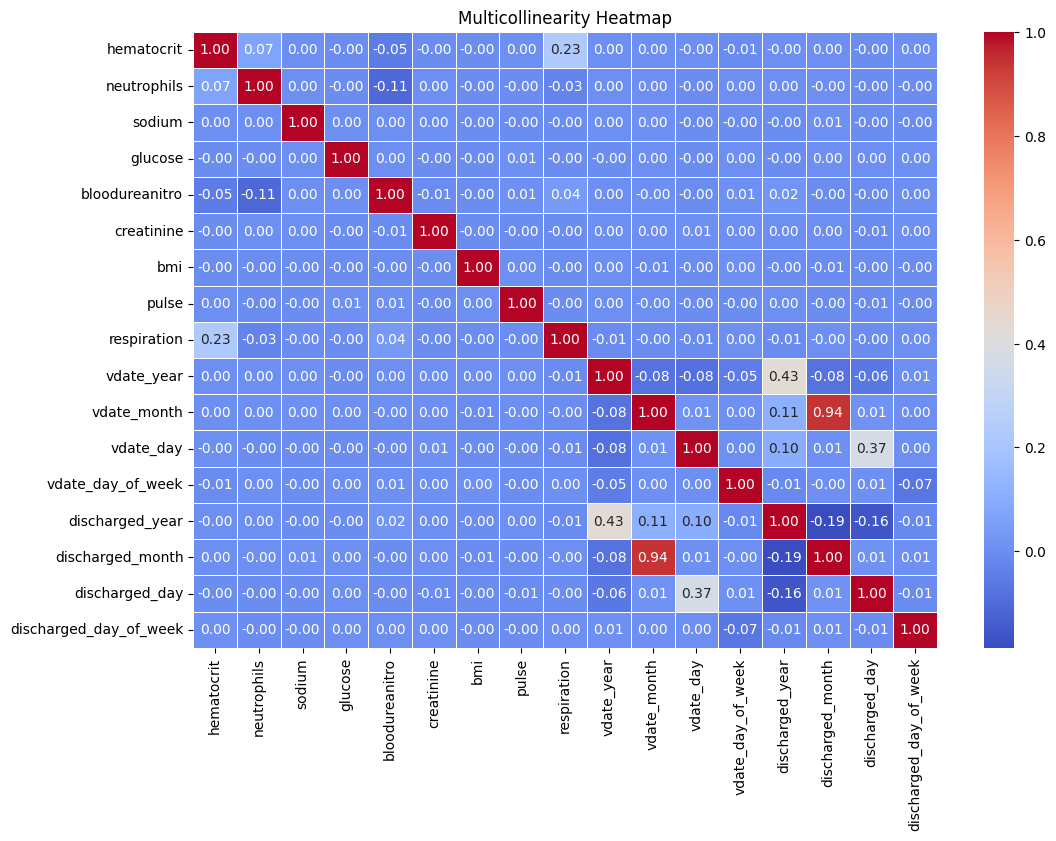

In [19]:
corr_matrix = los_data[['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse','respiration',
                       'vdate_year', 'vdate_month', 'vdate_day', 'vdate_day_of_week', 
                        'discharged_year', 'discharged_month', 'discharged_day', 'discharged_day_of_week' ]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Multicollinearity Heatmap')
plt.show()

In [20]:
# vdate and discharge date are too correlated
# will not include vdate in model
# Drop unneeded vdate

column_to_drop = ['vdate_year', 'vdate_month', 'vdate_day', 'vdate_day_of_week']
los_data = los_data.drop(column_to_drop, axis=1)

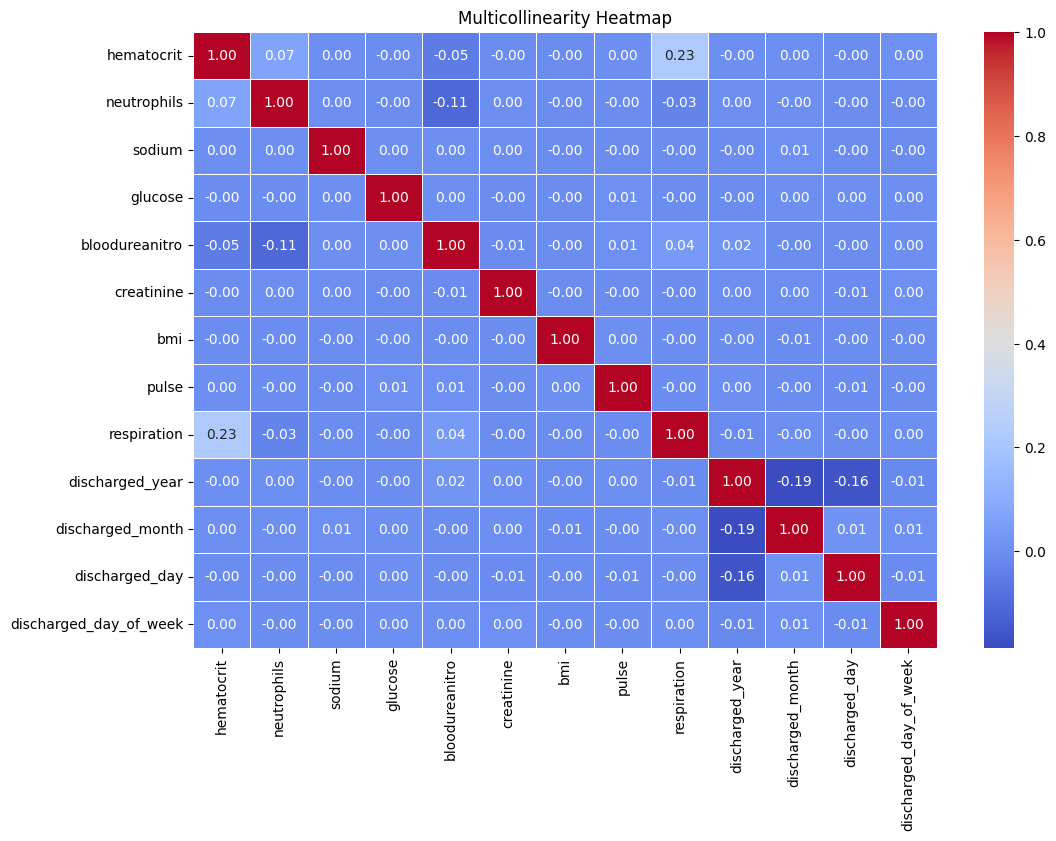

In [21]:
# Rerun correlation matrix
corr_matrix = los_data[['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse','respiration', 
                        'discharged_year', 'discharged_month', 'discharged_day', 'discharged_day_of_week']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Multicollinearity Heatmap')
plt.show()

In [22]:
los_data['longlengthofstay']=los_data['longlengthofstay'].astype('int')
los_data['facid_A']=los_data['facid_A'].astype('int')
los_data['facid_B']=los_data['facid_B'].astype('int')
los_data['facid_C']=los_data['facid_C'].astype('int')
los_data['facid_D']=los_data['facid_D'].astype('int')
los_data['facid_E']=los_data['facid_E'].astype('int')

los_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93801 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   rcount                      93801 non-null  int32  
 1   dialysisrenalendstage       93801 non-null  int32  
 2   asthma                      93801 non-null  int32  
 3   irondef                     93801 non-null  int32  
 4   pneum                       93801 non-null  int32  
 5   substancedependence         93801 non-null  int32  
 6   psychologicaldisordermajor  93801 non-null  int32  
 7   depress                     93801 non-null  int32  
 8   psychother                  93801 non-null  int32  
 9   fibrosisandother            93801 non-null  int32  
 10  malnutrition                93801 non-null  int32  
 11  hemo                        93801 non-null  int32  
 12  hematocrit                  93801 non-null  float64
 13  neutrophils                 938

In [23]:
## Ended up dropping discharged date too as was giving errors in model
column_to_drop = ['discharged_year', 'discharged_month', 'discharged_day', 'discharged_day_of_week']
los_data = los_data.drop(column_to_drop, axis=1)

In [24]:
# Set up scaling and encoding transformers
# los_data.head()

In [25]:
# Get all the feature related names and indices for later use

feature_names = los_data.columns.tolist()
feature_names.remove('longlengthofstay')

target_names = ['Extended LOS']

num_col_names = ['rcount', 'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 
                    'bmi', 'pulse', 'respiration']
num_col_indice = [feature_names.index(nc) for nc in num_col_names] # need this to fit alibi needs

cat_col_names = [fn for fn in feature_names if fn not in num_col_names]
cat_col_indice = [feature_names.index(cc) for cc in cat_col_names]

In [26]:
# Create the data scaling preprocessors 

scaler = MinMaxScaler() #StandardScaler()

# only numerical columns are scaled here
# in the future, categorical columns will need encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_col_indice)
    ],
    remainder='passthrough',
    sparse_threshold=0
)

In [27]:
# Split data into training and test

In [28]:
# Split the dataset into features (X) and the target variable (y)

X = los_data[feature_names] 
y = los_data['longlengthofstay']

# Split the data into a training set and a testing
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.2)

#
#
# Turn these into numpy arrays because alibi works with numpy array only
#
#
X_train, X_test, y_train, y_test = X_train_df.to_numpy(), X_test_df.to_numpy(), y_train_df.to_numpy(), y_test_df.to_numpy()

# Fit preprocessing transformations to the entire data set
# This is important especially when categorical data is involved
preprocessor.fit(X.to_numpy())

# Transform both train and test data
X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)

#*************************************************
# In summary, the following are finalized data
#    - DataFrame's
#                X, y 
#                X_train_df, X_test_df, y_train_df, y_test_df
#    - numpy array's
#                X_train, X_test, y_train, y_test
#    - normalized/encoded numpy array's
#                X_train_tf, X_test_tf
#**************************************************

In [29]:
## RUN SUPERVISED LEARNING MODELS
##
## ***NOTE: From here on all train and test data are in numpy format (no longer DataFrame)
##

In [30]:
# Logistic Regression

In [31]:
# Create a logistic regression model
logistic_regression = LogisticRegression(max_iter=5000)

# Fit the model to the training data
logistic_regression.fit(X_train_tf, y_train)

# Make predictions on the test set
y_pred_LR = logistic_regression.predict(X_test_tf)

# Probability of long stay
y_proba_LR = logistic_regression.predict_proba(X_test_tf)[:, 1]

In [32]:
# Calculate model statistics

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred_LR)
report = classification_report(y_test, y_pred_LR)
conf_matrix = confusion_matrix(y_test, y_pred_LR)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_LR)
recall = recall_score(y_test, y_pred_LR)
f1 = f1_score(y_test, y_pred_LR)

# Calculate AUC (Area Under the ROC Curve)
auc_LR = roc_auc_score(y_test, y_proba_LR)

# Get coefficients and feature names
coefficients = logistic_regression.coef_

In [33]:
# Print the model statististics - Logistic Regression

In [34]:
print(f'Accuracy: {accuracy}')
print('\nClassification Report:\n', report)
print('Confusion Matrix:\n', conf_matrix)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"AUC: {auc_LR:.2f}")

# Print the model's coefficients and intercept
print("Features:", feature_names)
print("Coefficients:", logistic_regression.coef_)
print("Intercept:", logistic_regression.intercept_)


Accuracy: 0.926336549224455

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     15970
           1       0.76      0.74      0.75      2791

    accuracy                           0.93     18761
   macro avg       0.86      0.85      0.85     18761
weighted avg       0.93      0.93      0.93     18761

Confusion Matrix:
 [[15322   648]
 [  734  2057]]
Precision: 0.76
Recall: 0.74
F1-score: 0.75
AUC: 0.96
Features: ['rcount', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'is_female', 'facid_A', 'facid_B', 'facid_C', 'facid_D', 'facid_E']
Coefficients: [[ 8.22938815e+00 -4.20221598e-01  1.42634755e+00 -7.46765650e-02
   1.24115876e-01  1.7606097

In [35]:
# Since the dataset is highly imbalanced, data balancing should be added in the future
# Furthermore, the area of precision recall curve (AUPRC) is a better indicator of 
# prediction performance. In sklearn, this value is estimated by the following function.

from sklearn.metrics import average_precision_score
auprc = average_precision_score(y_test, y_proba_LR)
print(f"AUPRC: {auprc}")

AUPRC: 0.8615172800258628


In [36]:
# Gradiant Boosting Classifier Model

In [37]:
# Create a Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, max_depth=3, min_samples_leaf=2, min_samples_split=10)

# Fit the model to the training data (Note: the data are in numpy format, which is needed by XAI packages)
gradient_boosting_classifier.fit(X_train_tf, y_train)

# Make predictions on the test data
y_pred_GB = gradient_boosting_classifier.predict(X_test_tf)

# Probability of long stay
y_proba_GB = gradient_boosting_classifier.predict_proba(X_test_tf)[:, 1]


In [38]:
#************
# Because DiCE library doesn't accept numpy, so fit another GB model here using DataFrame training data
#************
gbc_df = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, max_depth=3, min_samples_leaf=2, min_samples_split=10)

# Fit the model to the training data using DataFrame data, and no standardization/encoding is needed
# since the tree models don't really need them
gbc_df.fit(X_train_df, y_train_df)

GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=2,
                           min_samples_split=10, n_estimators=500)

In [39]:
# Calculate model statistics

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred_GB)
report = classification_report(y_test, y_pred_GB)
conf_matrix = confusion_matrix(y_test, y_pred_GB)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_GB)
recall = recall_score(y_test, y_pred_GB)
f1 = f1_score(y_test, y_pred_GB)

# Calculate AUC (Area Under the ROC Curve)
auc_GB = roc_auc_score(y_test, y_proba_GB)

In [40]:
print(f'Accuracy: {accuracy}')
print('\nClassification Report:\n', report)
print('Confusion Matrix:\n', conf_matrix)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"AUC: {auc_GB:.2f}")
#print("Feature Importance:", feature_importance)

# Print the model's coefficients and intercept
print("Features: ", feature_names)
print("Feature Importance: ", gradient_boosting_classifier.feature_importances_)

Accuracy: 0.9796386120142849

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15970
           1       0.93      0.93      0.93      2791

    accuracy                           0.98     18761
   macro avg       0.96      0.96      0.96     18761
weighted avg       0.98      0.98      0.98     18761

Confusion Matrix:
 [[15781   189]
 [  193  2598]]
Precision: 0.93
Recall: 0.93
F1-score: 0.93
AUC: 1.00
Features:  ['rcount', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'is_female', 'facid_A', 'facid_B', 'facid_C', 'facid_D', 'facid_E']
Feature Importance:  [7.38939912e-01 3.68086596e-02 1.26072512e-02 1.77163404e-02
 1.78233159e-02 1.548159

In [41]:
auprc = average_precision_score(y_test, y_proba_GB)
print(f"AUPRC: {auprc}")

AUPRC: 0.9857522715158253


In [42]:
# The gbc_df model should perform similarily. Let's do a sanity check here.
print(f"AUPRC for gbc_df model: {average_precision_score(y_test_df, gbc_df.predict_proba(X_test_df)[:,1])}")

AUPRC for gbc_df model: 0.9859471959913629


# Explainable AI Methods

In [43]:
### XAI libraries - SHAP and InterpretML (with SHAP)
import shap
from interpret import show
from interpret.blackbox import ShapKernel
from interpret.blackbox import LimeTabular
from interpret.blackbox import PartialDependence
#gradient_boosting_classifier.predict_proba([X_test.iloc[0]])
print("ok")


ok


In [44]:
# Local explanation using Kernel SHAP using interpret
predict_fn = lambda x: gradient_boosting_classifier.predict_proba(preprocessor.transform(x))[:,1]
gb_shap = ShapKernel(predict_fn, shap.sample(X_train, 100), feature_names=feature_names)
gb_shap_local = gb_shap.explain_local(X_test[:100], y_test[:100])
show(gb_shap_local)

  0%|          | 0/100 [00:00<?, ?it/s]

<!-- http://127.0.0.1:7001/3137527229360/ -->

In [45]:
# Local explanation with LIME using interpret
gb_lime = LimeTabular(predict_fn, X_train, feature_names=feature_names)
gb_lime_local = gb_lime.explain_local(X_test[0:100], y_test[0:100])
show(gb_lime_local)


<!-- http://127.0.0.1:7001/3137683976048/ -->

In [46]:
# Global explanation with PDP using interpret
predict_fn = lambda x: gradient_boosting_classifier.predict_proba(preprocessor.transform(x))[:, 1]
gb_pdp = PartialDependence(predict_fn, X_train, feature_names=feature_names)
gb_pdp_global = gb_pdp.explain_global()
show(gb_pdp_global)

<!-- http://127.0.0.1:7001/3137527111344/ -->

In [47]:
# Explanation using the SHAP library directly
# The first parameter must be the model itself. We can't use the trick of predict_fn here.
# Fortunately, for tree models, we shouldn't have used data normalization anyway.

explainer = shap.TreeExplainer(gradient_boosting_classifier, feature_names=feature_names)
# Calculate shapley values for test data
#shap_values = explainer.shap_values(X_test)
shap_values = explainer(X_test_tf[0:100])

# Investigating the values (classification problem)
# class 0 = contribution to class 1
# class 1 = contribution to class 2
#print(shap_values[1].shape)
#shap_values

explainer.expected_value

array([-6.79994156])

In [48]:
# SHAP library visualization

shap.initjs()

# Local explanation using Force plot

shap.plots.force(shap_values[33])

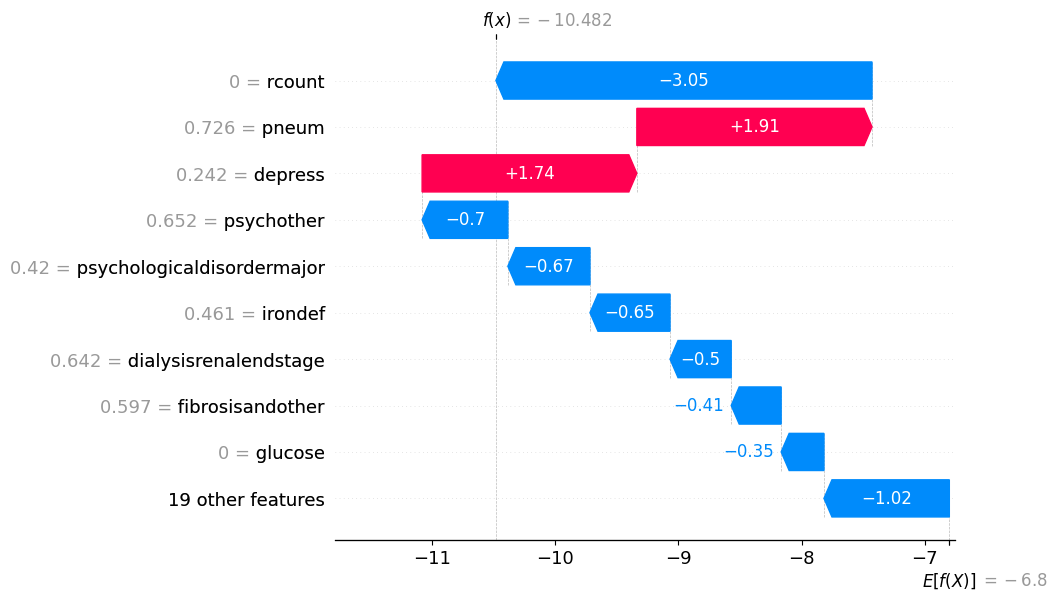

In [49]:
# Local explanation using SHAP's Water Fall plot 

shap.plots.waterfall(shap_values[33])

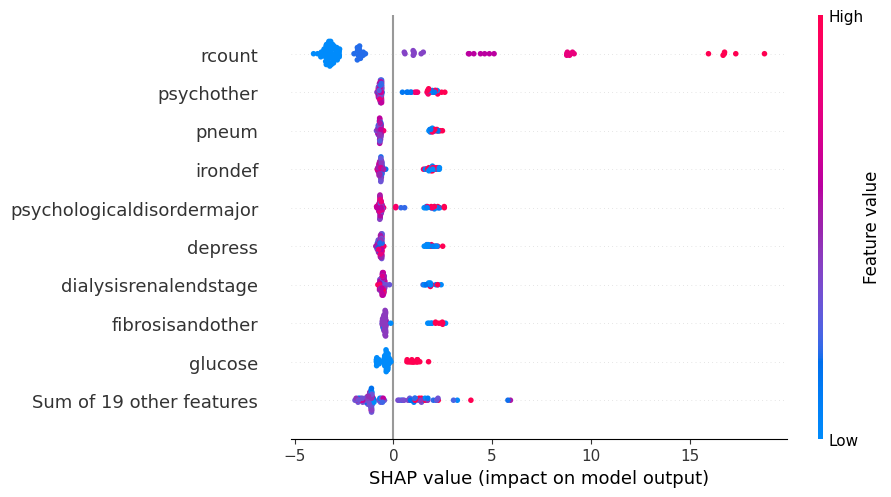

In [50]:
# Global explanation using SHAP Feature Summary

shap.plots.beeswarm(shap_values)


In [51]:
# XAI library for counterfactual analysis using DiCE

import dice_ml

data_dice = dice_ml.Data(dataframe=pd.concat([X_train_df, y_train_df], axis=1), 
                         continuous_features=num_col_names,
                         outcome_name='longlengthofstay')
model_dice = dice_ml.Model(model=gbc_df,
                           backend='sklearn')
exp_dice = dice_ml.Dice(data_dice, model_dice, method='random')

cf = exp_dice.generate_counterfactuals(X_test_df[0:1], total_CFs=10, desired_class='opposite')

c:\Users\rcc00\anaconda3\envs\python39\lib\site-packages\dice_ml\utils\exception.py:12: UserWarning:

UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


In [52]:
# Displaying counterfactuals as a dataframe

cf.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,rcount,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,malnutrition,hemo,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,is_female,facid_A,facid_B,facid_C,facid_D,facid_E,longlengthofstay
0,1,0,0,0,0,0,1,0,1,0,1,0,11.3,6.4,136.820557,152.228958,18.0,0.721182,28.347311,65,6.5,3,0,0,0,0,0,1,0



Diverse Counterfactual set (new outcome: 1.0)


,rcount,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,malnutrition,hemo,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,is_female,facid_A,facid_B,facid_C,facid_D,facid_E,longlengthofstay
0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,11.3,6.4,136.8205509,152.2289592,-,0.721181839,28.34731183,48.0,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,11.3,6.4,136.8205509,152.2289592,-,0.721181839,28.34731183,-,-,3.0,0.0,0.0,1,0.0,0.0,1.0,1
2,-,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,11.3,6.4,136.8205509,152.2289592,44.5,0.721181839,28.34731183,47.0,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,11.3,6.4,136.8205509,152.2289592,-,0.721181839,28.34731183,88.0,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,5.0,0.0,0.0,0.0,0.0,0.0,-,0.0,1.0,0.0,1.0,0.0,11.3,6.4,136.8205509,152.2289592,-,0.721181839,28.34731183,-,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1
5,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,11.3,6.4,136.8205509,96.1126,-,0.721181839,28.34731183,-,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1
6,5.0,0.0,0.0,-,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,11.3,6.4,136.8205509,152.2289592,-,0.721181839,28.34731183,-,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1
7,-,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,11.3,6.4,131.29181,152.2289592,51.7,0.721181839,28.34731183,-,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1
8,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,1.0,0.0,11.3,6.4,136.8205509,152.2289592,-,0.721181839,28.34731183,-,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1
9,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-,1.0,0.0,11.3,6.4,136.8205509,152.2289592,-,0.721181839,28.34731183,-,-,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [53]:
# PDP, ICE, ALE and many other methods using the alibi XAI library

# PDP using alibi

import alibi.explainers as aliexp
predict_fn = lambda x: gradient_boosting_classifier.predict_proba(preprocessor.transform(x))[:, 1]
pd_explainer = aliexp.PartialDependence(predictor=predict_fn,
                              feature_names=feature_names,
                                target_names=target_names,
                                categorical_names=cat_col_names)
pd_exp = pd_explainer.explain(X=X_test,
                        kind='average')

AttributeError: 'GrouperView' object has no attribute 'join'

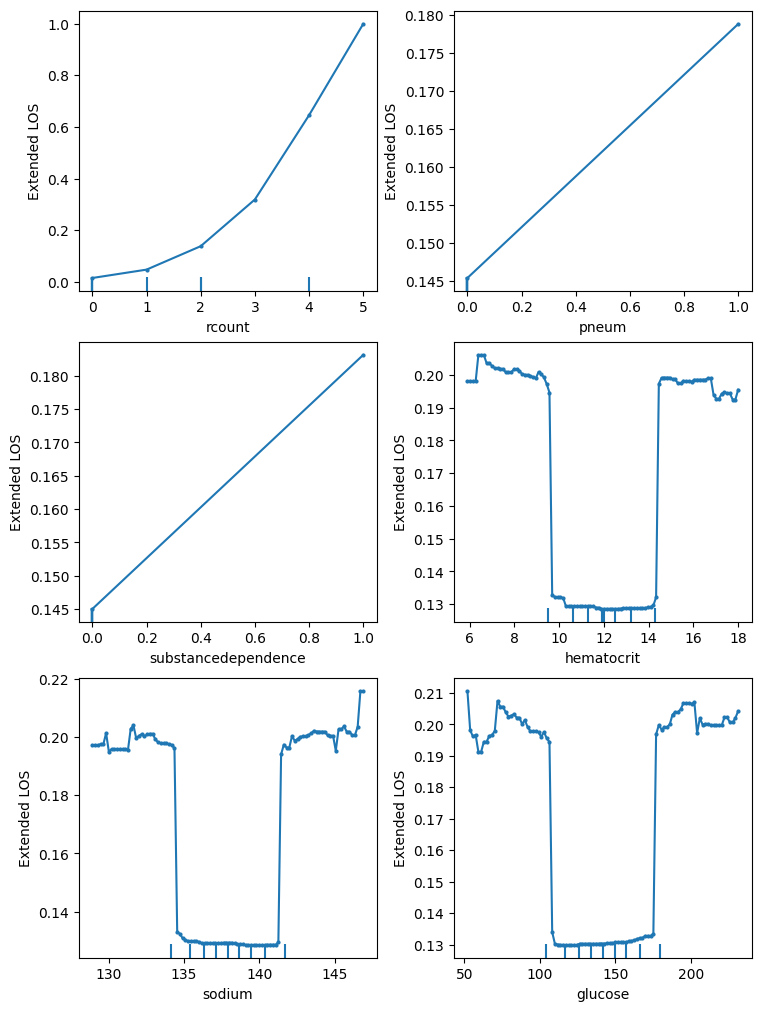

In [56]:
#%xmode minimal

fig, axs = plt.subplots(3, 2, figsize=(7.5, 10), sharey='none', layout='constrained')
aliexp.plot_pd(exp=pd_exp, ax=axs, features=[0, 4, 5, 12, 14, 15])

In [ ]:
# ALE plot using alibi

from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale

predict_fn = lambda x: gradient_boosting_classifier.predict_proba(preprocessor.transform(x))[:,1]
ale = ALE(predict_fn, feature_names=feature_names)
exp = ale.explain(X_test)


In [ ]:

plot_ale(exp, n_cols=2, sharey=None, features=[0, 4, 5, 12, 14, 15], line_kw={'label': 'Probability of "longlengthofstay" class'}, fig_kw={'figheight': 10, 'figwidth': 7.5})


In [ ]:
# Data explanation and visualization using SweetViz
#%pip install sweetviz

import sweetviz
los_data_viz = sweetviz.analyze([los_data, 'LOS'], target_feat='longlengthofstay')
los_data_viz.show_html('sweetviz-los.html')

# Rcount analysis

# Sodium